In [1]:
from sqlalchemy import create_engine

import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tag import StanfordNERTagger

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans

import nltk
import string
from functools import reduce
from math import log

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')


#own Kmeans
from kmeans_algorithm import Kmeans

In [2]:
# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()

In [3]:
stringDB = "mysql+pymysql://root:@localhost:3306/oerintegrationdb"
# Conexion a la BD
engine = create_engine(stringDB)

In [4]:
query = "SELECT * FROM cleantriple where predicate = 'title' limit 950;"
df = pd.read_sql(query, engine)

In [9]:
#usando libreria para vectorizar
#1v
#vectorizer = TfidfVectorizer()
vectorizer = TfidfVectorizer(stop_words = 'english',#tokenizer = tokenize_and_stem,
                             max_features = 20000)
vectors = vectorizer.fit_transform(df['object'])
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
dfvec = pd.DataFrame(denselist, columns=feature_names)
dfvec

,100,1001,1002,101,103,12,13,15,1500,1650,...,writers,writing,year,years,yeats,yes,young,youtube,zip,zoology
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.409249,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Running Model Iteration 0 
Running Model Iteration 100 
Running Model Iteration 200 
Running Model Iteration 300 
Running Model Iteration 400 
Running Model Iteration 500 
Model finished running


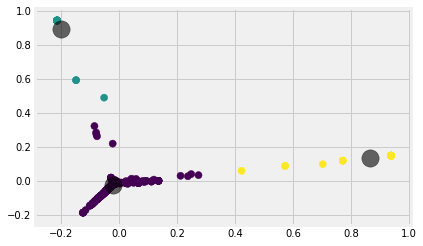

In [6]:
#Implementación propia
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(dfvec)
dataToElbow = Y_sklearn
test_e = Kmeans(3, 1, 600)
fitted = test_e.fit_kmeans(Y_sklearn)
predicted_values = test_e.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=predicted_values, s=50, cmap='viridis')

centers = fitted.centroids
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);

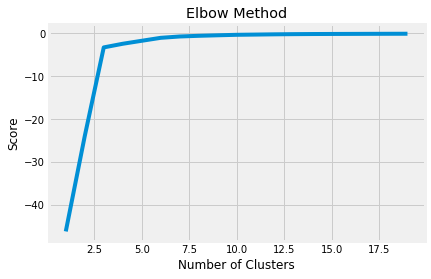

In [7]:
#optimal cluster number: Elbow Method
number_clusters = range(1, 20)

kmeansNC = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]

score = [kmeansNC[i].fit(dataToElbow).score(dataToElbow) for i in range(len(kmeansNC))]

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

[0 1 2]


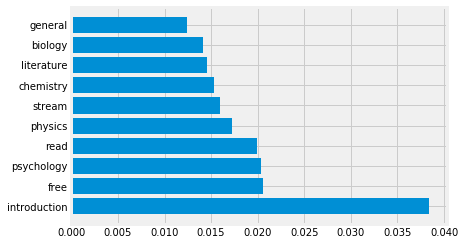

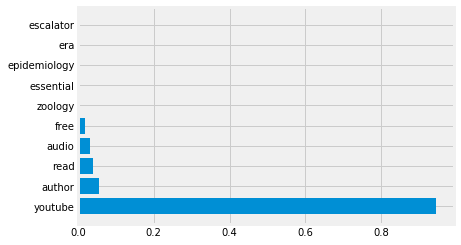

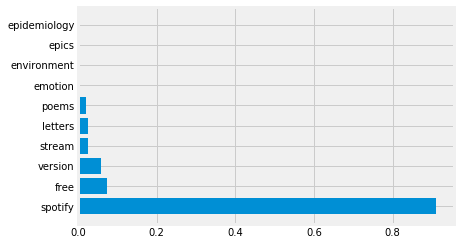

In [8]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(predicted_values)
    print(labels)
    dfs = []
    for label in labels:
        id_temp = np.where(predicted_values==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = feature_names
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs
dfs = get_top_features_cluster(dfvec.values, predicted_values,10)
for d in dfs:
    height = [h[1] for h in d.values]
    bars = [h[0] for h in d.values]
    y_pos = np.arange(len(bars))
    plt.barh(y_pos, height)
    plt.yticks(y_pos, bars)
    plt.show()